## Toy Problems Rozanoff 2025
### PCA and Kernel PCA

### 1. Import Required Libraries


In [ ]:
import numpy as np            
import pandas as pd                    
import matplotlib.pyplot as plt         

# Import machine learning libraries
from sklearn.decomposition import PCA           
from sklearn.preprocessing import StandardScaler 
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# further imports for kernel PCA
from itertools import accumulate
import seaborn as sns
from sklearn.decomposition import KernelPCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# inline plotting
%matplotlib inline 

### 2. PCA Classification (Breast Cancer dataset)

#### 2a. Data Preparation

In [2]:
# Load the breast cancer dataset from sklearn
breast = load_breast_cancer()
breast_data = breast.data                    # Features: (569 samples, 30 features)
breast_labels = breast.target                # Labels: 0=Benign, 1=Malignant
labels = np.reshape(breast_labels, (569, 1)) # Reshape labels to column vector

# Combine features and labels into a single array
final_breast_data = np.concatenate([breast_data, labels], axis=1)

# Convert numpy array to pandas DataFrame for easier manipulation
breast_dataset = pd.DataFrame(final_breast_data)

# Get feature names from the dataset
features = breast.feature_names
features_labels = np.append(features, 'label')  # Add 'label' column name

# Assign column names to the dataframe
breast_dataset.columns = features_labels

# Display first 5 rows
breast_dataset.head()

# Replace numeric labels with more interpretable text using the recommended approach
breast_dataset['label'] = breast_dataset['label'].replace(0, 'Benign')      # 0 → Benign
breast_dataset['label'] = breast_dataset['label'].replace(1, 'Malignant')   # 1 → Malignant

#### 2b. Data refinement

In [19]:
x = breast_dataset.loc[:, features].values
x = StandardScaler().fit_transform(x) # normalizing the features

feat_cols = ['feature'+str(i) for i in range(x.shape[1])]
normalised_breast = pd.DataFrame(x,columns=feat_cols)

#### 2c. PCA and visualisation

Explained variability per principal component: [0.44272026 0.18971182]


<Figure size 640x480 with 0 Axes>

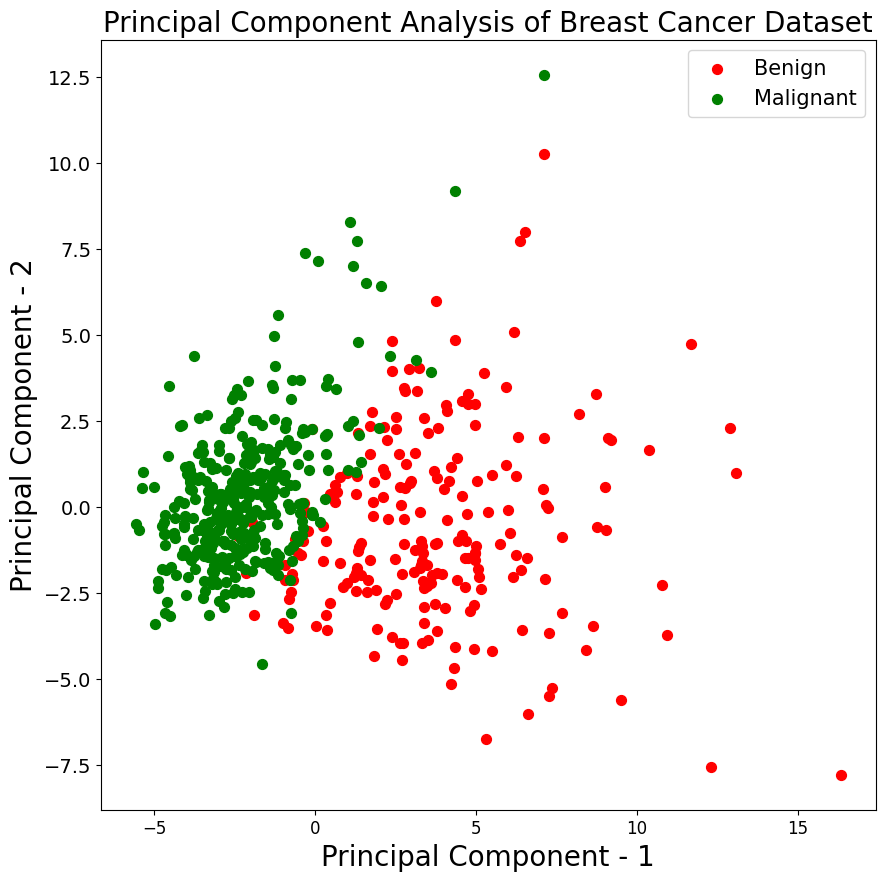

In [4]:
# dimension reduction
pca_breast = PCA(n_components=2)
principalComponents_breast = pca_breast.fit_transform(x)

principal_breast_Df = pd.DataFrame(data = principalComponents_breast
             , columns = ['principal component 1', 'principal component 2'])

print('Explained variability per principal component: {}'.format(pca_breast.explained_variance_ratio_))

plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Breast Cancer Dataset",fontsize=20)
targets = ['Benign', 'Malignant']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = breast_dataset['label'] == target
    plt.scatter(principal_breast_Df.loc[indicesToKeep, 'principal component 1']
               , principal_breast_Df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})


#### 3. PCA + Linear Regression (mtcars dataset)

#### 3a. Data preparation

In [20]:
# define URL where data is located
url = "https://raw.githubusercontent.com/Statology/Python-Guides/main/mtcars.csv"

# read in data
data_full = pd.read_csv(url)

# select subset of data
data = data_full[["mpg", "disp", "drat", "wt", "qsec", "hp"]]

# view first six rows of data
data[0:6]

,mpg,disp,drat,wt,qsec,hp
0,21.0,160.0,3.90,2.620,16.46,110
1,21.0,160.0,3.90,2.875,17.02,110
2,22.8,108.0,3.85,2.320,18.61,93
3,21.4,258.0,3.08,3.215,19.44,110
4,18.7,360.0,3.15,3.440,17.02,175
5,18.1,225.0,2.76,3.460,20.22,105


#### 3b. PCA and Regression

Text(0.5, 1.0, 'hp')

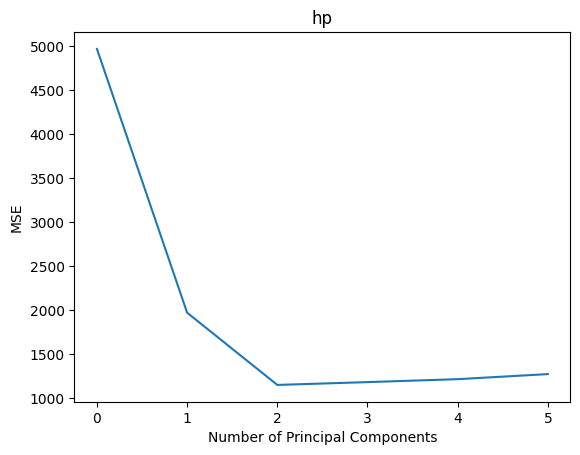

In [7]:
#define predictor and response variables
X = data[["mpg", "disp", "drat", "wt", "qsec"]]
y = data[["hp"]]

#scale predictor variables
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

#define cross validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept
score = -1*model_selection.cross_val_score(regr,
           np.ones((len(X_reduced),1)), y, cv=cv,
           scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 6):
    score = -1*model_selection.cross_val_score(regr,
               X_reduced[:,:i], y, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot cross-validation results    
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('hp')

#### 3c. Evaluation of performance

In [8]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)


array([69.83, 89.35, 95.88, 98.95, 99.99])

#### 3d. Training and RMSE

In [9]:
#split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0) 

#scale the training and testing data
X_reduced_train = pca.fit_transform(scale(X_train))
X_reduced_test = pca.transform(scale(X_test))[:,:1]

#train PCR model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:1], y_train)

#calculate RMSE
pred = regr.predict(X_reduced_test)
np.sqrt(mean_squared_error(y_test, pred))

np.float64(40.209642107611515)

#### 3e. RMSE performance as a function of pca_variance

In [ ]:
# Define different variance thresholds to test
pca_variances = [0.85, 0.95, 0.99]

# Store results
mtcars_results = []

# Train and evaluate for each variance
for variance_threshold in pca_variances:
    
    # Create PCA with variance threshold
    pca_test = PCA(n_components=variance_threshold)
    
    # Fit PCA on scaled training data and transform both sets
    X_reduced_train = pca_test.fit_transform(scale(X_train))
    X_reduced_test = pca_test.transform(scale(X_test))
    
    # Get actual number of components and variance retained
    n_components = pca_test.n_components_
    explained_var = np.sum(pca_test.explained_variance_ratio_)
    
    # Train linear regression model
    regr = LinearRegression()
    regr.fit(X_reduced_train, y_train)
    
    # Make predictions and calculate MSE
    pred = regr.predict(X_reduced_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    
    # Store results
    mtcars_results.append({
        'Variance Threshold': f"{variance_threshold*100:.0f}%",
        'N Components': n_components,
        'Variance Retained': f"{explained_var:.4f}",
        'MSE': f"{mse:.4f}",
        'RMSE': f"{rmse:.4f}"
    })


# ==================== CREATE RESULTS DATAFRAME ====================
mtcars_results_df = pd.DataFrame(mtcars_results)
print(mtcars_results_df.to_string(index=False))


Variance Threshold  N Components Variance Retained      MSE    RMSE
               85%             2            0.8956 898.4328 29.9739
               95%             3            0.9641 879.8577 29.6624
               99%             4            0.9921 921.4788 30.3559


### 4. Kernel PCA

#### 4a. Setup

In [ ]:
# Surpress warnings from using older version of sklearn:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set_style('white')

#### 4b. Function to plot projection onto vector

In [23]:
def plot_proj(A,v,y,name=None):

    plt.scatter(A[:,0],A[:,1],label='data',c=y,cmap='viridis')
    
    #plt.plot(np.linspace(A[:,0].min(),A[:,0].max()),np.linspace(A[:,1].min(),A[:,1].max())*(v[1]/v[0]),color='black',linestyle='--',linewidth=1.5,label=name)   
    plt.plot(np.linspace(-1,1),np.linspace(-1,1)*(v[1]/v[0]),color='black',linestyle='--',linewidth=1.5,label=name)  
    # Run through all the data

    for i in range(len(A[:,0])-1):
        #data point 
        w=A[i,:]

        # projection
        cv = (np.dot( A[i,:],v))/np.dot(v,np.transpose(v))*v

        # line between data point and projection
        plt.plot([A[i,0],cv[0]],[A[i,1],cv[1]],'r--',linewidth=1.5)
    plt.plot([A[-1,0],cv[0]],[A[-1,1],cv[1]],'r--',linewidth=1.5,label='projections' )
    plt.legend()
    plt.show()



#### Kernel PCA concept
Kernel PCA maps data into higher dimensional space then performs PCA.